In [8]:
# Setup code for the notebook
%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from ipytools import display_imshow
from ipytools import readGTIFF  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


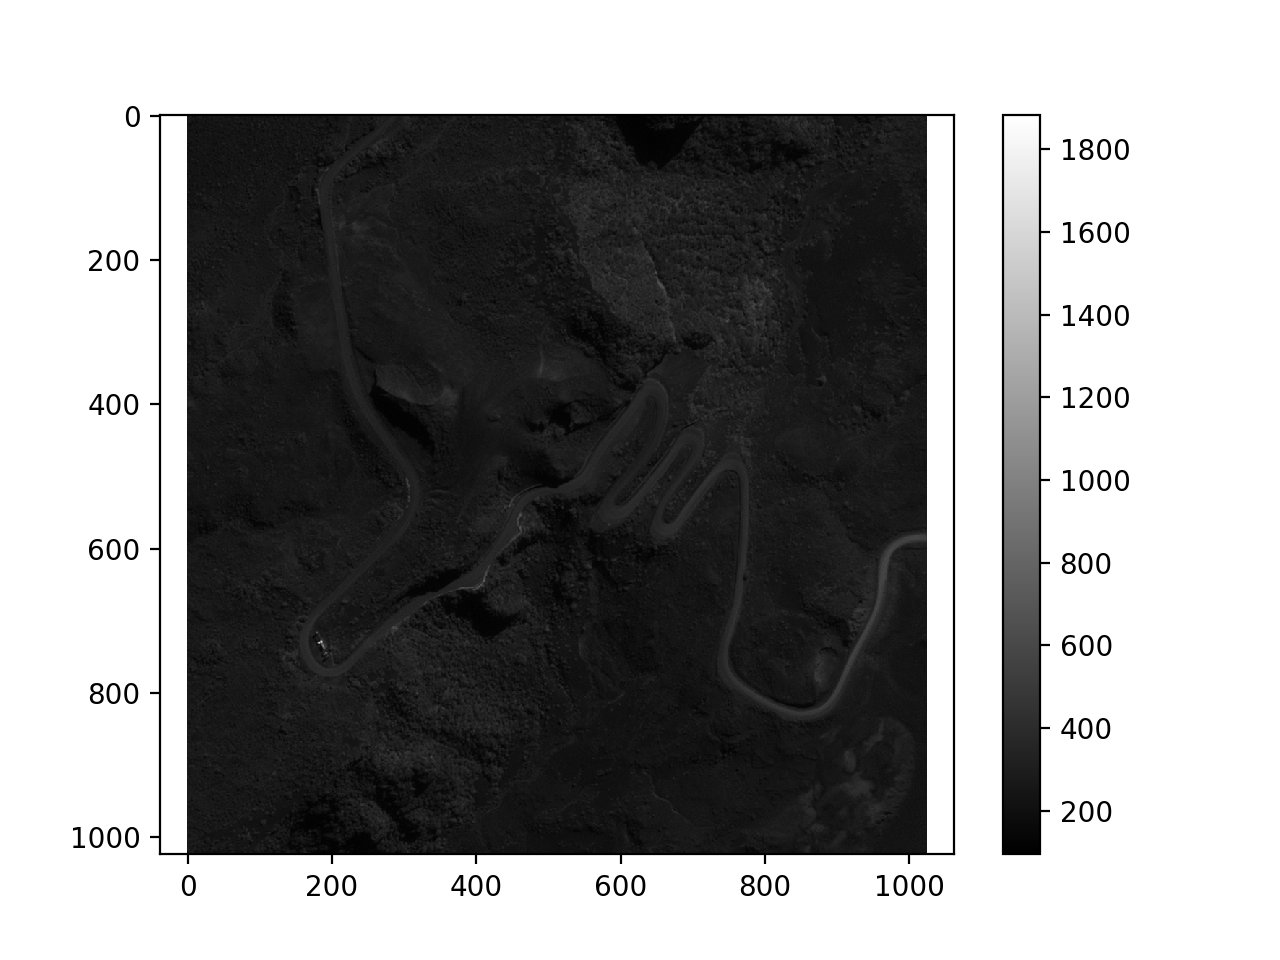

In [9]:
filename_1 = '../testdata/input_pair/img_01.tif'
a = readGTIFF(filename_1)
display_imshow(a)

<IPython.core.display.Javascript object>


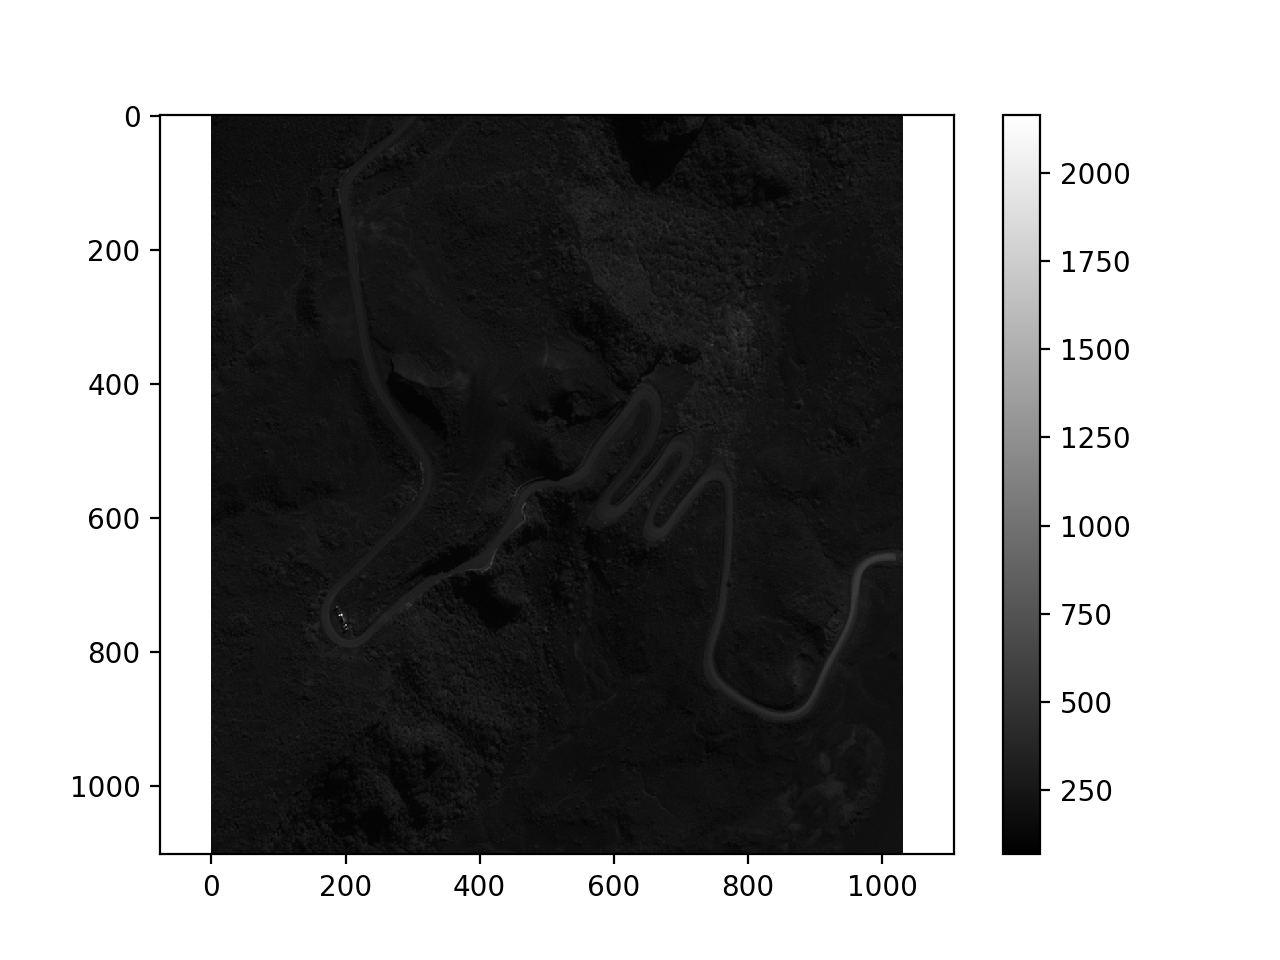

In [10]:
filename_2 = '../testdata/input_pair/img_02.tif'
a = readGTIFF(filename_2)
display_imshow(a)

In [32]:
# Setup code for the notebook
%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=150)
from scipy import ndimage

import ad             # automatic differentiation

import ipytools       # course toolbox
import ipytools2      # TP2 toolbox
from ipytools import printbf         # boldface print
from ipytools import display_image   # display image in the notebook
from ipytools import display_imshow  # display image(arrays) in notebook
from ipytools import readGTIFF       # read/write GeoTIFF, PNG, and JPEG
from ipytools import readGTIFFmeta   # and metadata
from ipytools import writeGTIFF
import TP1_solutions

# import the solutions to the exercises
#import TP2_solutions as sol
import solutionsTP2 as sol

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data available for this session

Since high-resolution WorldView-3 images are not freely downloadable (you have to buy them), a sample set of such images is provided in a remote folder. The content of that folder can be listed with the `listFD` function of the `ipytools2` module.

In [33]:
# list the tiff images available in the remote folder
images = ipytools2.listFD('http://menthe.ovh.hw.ipol.im:8080/IARPA_data/cloud_optimized_geotif', 'TIF')
print('Found {} images'.format(len(images)))
images[27]

Found 49 images


'http://menthe.ovh.hw.ipol.im:8080/IARPA_data/cloud_optimized_geotif/18DEC15WV031000015DEC18140455-P1BS-500515572010_01_P001_________AAE_0AAAAABPABJ0.TIF'

In [34]:
# sort the images by acquisition date
images.sort(key=ipytools2.acquisition_date)

### Images geographic footprints

We've seen in TP1 how to get the longitude, latitude bounding box of an image. Let's use the `get_image_longlat_polygon` of `TP1_solutions` to display on a map the footprints of images 27 and 28.

In [35]:
# create a map
m = ipytools.clickablemap()

# display the footprint polygons
for f in images[27:29]:
    footprint = TP1_solutions.get_image_longlat_polygon(f)
    m.add_GeoJSON(footprint)

# center the map on the center of the last footprint
m.center = np.mean(footprint['coordinates'][0], axis=0).tolist()[::-1]
display(m)

Map(center=[-34.473125, -58.609583333333326], controls=(DrawControl(circle={'shapeOptions': {'color': '#0000FF'}}, layer=FeatureGroup(), polygon={'shapeOptions': {'color': '#0000FF'}}, polyline={'shapeOptions': {'color': '#0000FF'}}, rectangle={'shapeOptions': {'color': '#0000FF'}}),), layers=(TileLayer(options=['detect_retina', 'opacity', 'max_zoom', 'tile_size', 'attribution', 'min_zoom'], url='https://mt1.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}'), GeoJSON(data={'coordinates': [[[-58.5249980655604, -34.5377792019645], [-58.6913908233285, -34.5497239241416], [-58.6913908233285, -34.415276353591], [-58.5249980655604, -34.403331631414]]], 'type': 'Polygon'}), GeoJSON(data={'coordinates': [[[-58.5198590248874, -34.543543303997], [-58.6995854260159, -34.5378487271452], [-58.6993076417792, -34.402706696003], [-58.5195812406508, -34.4084012728548]]], 'type': 'Polygon'})), layout=Layout(height='500px', width='100%'), options=['box_zoom', 'inertia_deceleration', 'keyboard_zoom_offset', 'scroll_wheel_zoom', 'double_click_zoom', 'attribution_control', 'keyboard_pan_offset', 'dragging', 'tap_tolerance', 'zoom_control', 'world_copy_jump', 'center', 'inertia', 'zoom_start', 'touch_zoom', 'zoom_animation_threshold', 'keyboard', 'zoom', 'close_popup_on_click', 'min_zoom', 'max_zoom', 'bounce_at_zoom_limits', 'inertia_max_speed', 'tap'], scroll_wheel_zoom=True, zoom=13)

### Images RPC coefficients

The 90 coefficients (20 \* 2 \* 2 + 10) of the RPC projection function associated to each image are stored in the image GeoTIFF header. They can be read with the `rpc_from_geotiff` function of the `ipytools2` module. This function returns an instance of the class `rpc_model.RPCModel` which contains the RPC coefficients and a `projection` method.

In [36]:
rpc = ipytools2.rpc_from_geotiff(images[0])
print(rpc)


    # Projection function coefficients
      col_num =  0.0031 -1.0153  0.0002  0.0079 -0.0032 -0.0004 -0.0002 -0.0021  0.0000  0.0000 -0.0000  0.0000  0.0002  0.0000 -0.0000 -0.0003 -0.0000 -0.0000  0.0000 -0.0000
      col_den =  1.0000  0.0010 -0.0033 -0.0004  0.0000 -0.0000 -0.0000 -0.0000  0.0001 -0.0000 -0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
      row_num = -0.0116 -0.0222  1.0376 -0.0143  0.0014 -0.0000  0.0007 -0.0003  0.0088 -0.0000  0.0000  0.0000  0.0000  0.0000 -0.0001 -0.0002 -0.0001  0.0000  0.0000  0.0000
      row_den =  1.0000 -0.0017  0.0029 -0.0009 -0.0000 -0.0000 -0.0000 -0.0000  0.0002 -0.0001 -0.0000  0.0000  0.0000  0.0000  0.0000  0.0001  0.0000  0.0000 -0.0000  0.0000

    # Offsets and Scales
      row_offset = 14359.0
      col_offset = 13615.0
      lat_offset = -34.4754
      lon_offset = -58.611
      alt_offset = 31.0
      row_scale = 14360.0
      col_scale = 13617.0
      lat_scale = 0.0688
      lon_scale = 0.

# Get the coordinates of the selected area of interest (AOI)

In [37]:
try:  # get the coordinates of the last polygon drawn
    aoi = m.AOIs[-1]['geometry']

except IndexError:  # predefined polygon on Buenos Aires if nothing was drawn
    aoi = {'type': 'Polygon',
           'coordinates': [[[-58.588104, -34.492197],
                            [-58.588104, -34.488103],
                            [-58.582075, -34.488103],
                            [-58.582075, -34.492197],
                            [-58.588104, -34.492197]]]}

# draw the polygon and center map
m.add_GeoJSON(aoi)
m.center = aoi['coordinates'][0][0][::-1]

printbf("Coordinates of the selected polygon (lon, lat):")
print(np.array(aoi['coordinates'][0]))

__Coordinates of the selected polygon (lon, lat):__

[[-58.588104 -34.492197]
 [-58.588104 -34.488103]
 [-58.582075 -34.488103]
 [-58.582075 -34.492197]
 [-58.588104 -34.492197]]


# Exercises

**Exercise 1.** Implement the `projection_of_3d_vertical_line` function in the module `solutionsTP2`. This function samples the projection of a 3D vertical line on the image plane by using the RPC _projection_ function: $(\lambda, \theta, h) \mapsto (x, y)$ and varying $h$.

It takes as input arguments (see its prototype and docstring in the module `solutionsTP2`):
* `rpc`: instance of the `rpc_model.RPCModel` class
* `lon, lat`: geographic coordinates of the ground point through which the vertical line passes
* `h_min, h_max`: min, max altitude bounds of the vertical line
* `h_step`: step used to sample the vertical line

It returns a list of pairs of `x, y` coordinates of image pixels.

To implement this function you may use the `projection` method of the `rpc_model.RPCModel` object. This method implements the RPC _projection_ function: it receives as arguments three geographic coordinates `lon, lat, h` and returns two image coordinates `x, y`.

The code below calls your `projection_of_3d_vertical_line` function to plot the image projections of the sampled vertical line passing through the center of the area that you've selected in the map. The color varies with $h$.

<IPython.core.display.Javascript object>


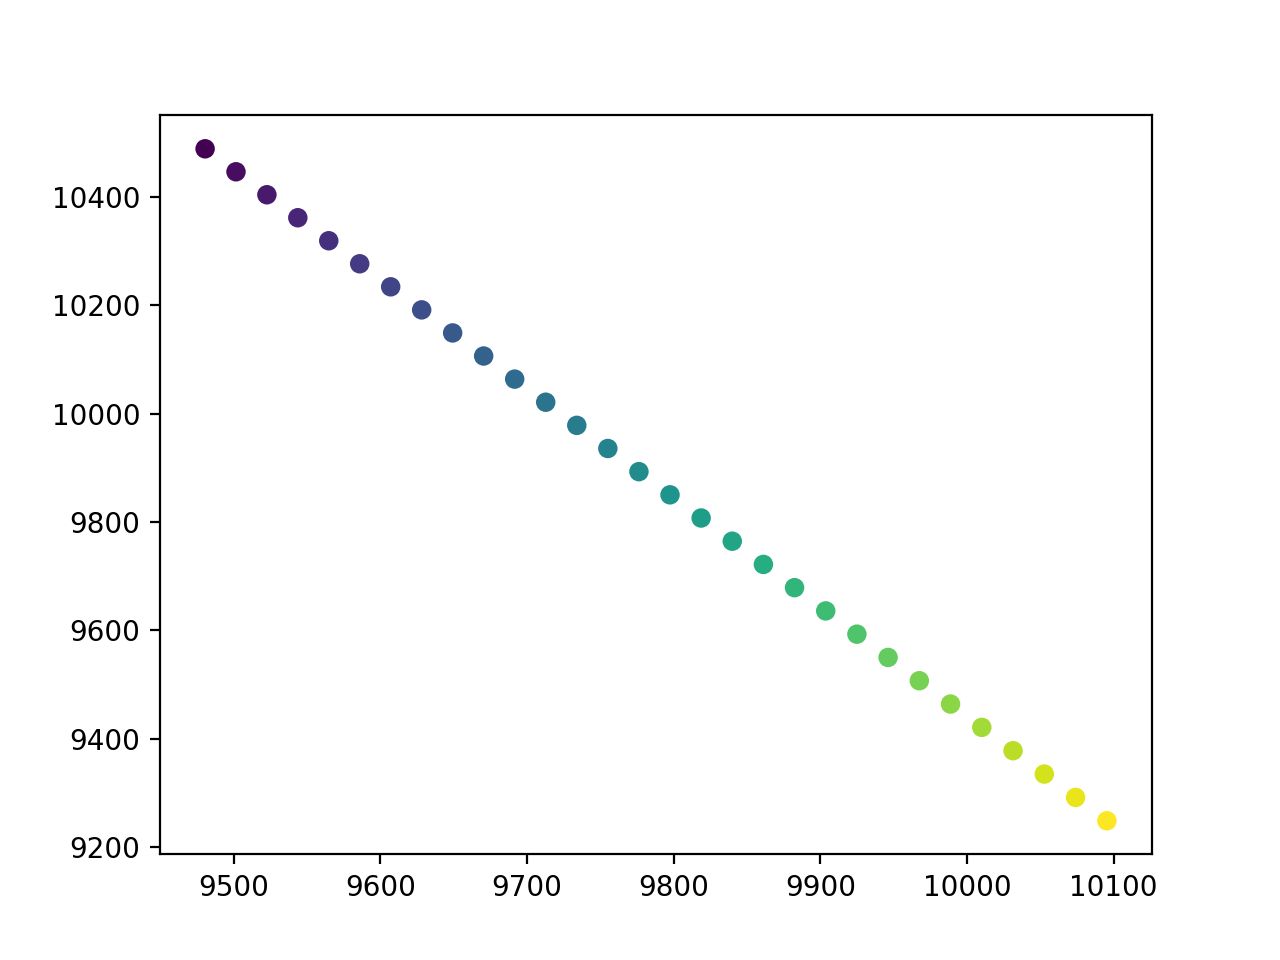

In [38]:
# plot the projection of a 3d vertical line on the image plane
lat, lon = m.center
h_min, h_max, h_step = 0, 3000, 100
p = np.array(sol.projection_of_3d_vertical_line(rpc, lon, lat, h_min, h_max, h_step))
plt.figure()
plt.scatter(p[:, 0], p[:, 1], c=np.arange(h_min, h_max, h_step))

**Exercise 2.** Implement the `crop_aoi` function in the module `solutionsTP2`. This function crops an area of interest (AOI) defined with geographic coordinates in a GeoTIFF image using its RPC functions.

It takes as input arguments (see its prototype and docstring in the module `solutionsTP2`):
* `geotiff`: path to the input GeoTIFF image file
* `aoi`: GeoJSON polygon
* `fname`: path to the output crop file

It produces a file `fname` containing the image crop, and returns four integers `x, y, w, h` giving the pixel coordinates of the crop:
* `x, y`: coordinates of the top-left corner of the crop in the original image
* `w, h`: width and height of the crop

To implement this function you may use:
* `ipytools2.rpc_from_geotiff` to read the RPC coefficients and get an `rpc_model.RPCModel` object
* the `projection` method of the `rpc_model.RPCModel` object
* `ipytools2.bounding_box2D` to compute a horizontal/vertical rectangular bounding box
* `ipytools2.image_crop_gdal` to actually do the crop

The `projection` function needs an altitude coordinate `h`, which **is not** contained in the `aoi` GeoJSON polygon. For this exercise, **we assume that `h` is zero**.

The code below calls your `crop_aoi` function to crop the area selected in the map from image 10 and displays the crop.

In [39]:
# crop the selected AOI in image number 10
bbx = sol.crop_aoi(images[10], aoi, 'crop.tif')

# display the crop
a = readGTIFF('crop.tif')
#display_imshow(a)

# overlay the crop on a map using the code implemented during TP1
TP1_solutions.Exercise10('crop.tif')

RUN: gdalwarp -overwrite  -of GTiff -t_srs "+proj=longlat +datum=WGS84" crop.tif tmp_ex10_longlat.tif
{'coordinates': [[[-58.5870624413434, -34.488809307065], [-58.5811011372665, -34.488809307065], [-58.5811011372665, -34.4930555176007], [-58.5870624413434, -34.4930555176007]]], 'type': 'Polygon'}


VBox(children=(HBox(children=(Button(description='hide', layout=Layout(width='auto'), style=ButtonStyle()), Button(description='hidePoly', layout=Layout(width='auto'), style=ButtonStyle()), Label(value=''))), Map(center=[-34.488809307065, -58.5870624413434], layers=(TileLayer(options=['detect_retina', 'opacity', 'max_zoom', 'tile_size', 'attribution', 'min_zoom'], url='https://mt1.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}'), Polygon(fill_opacity=0.25, locations=[[-34.488809307065, -58.5870624413434], [-34.488809307065, -58.5811011372665], [-34.4930555176007, -58.5811011372665], [-34.4930555176007, -58.5870624413434]], options=['class_name', 'pointer_events', 'opacity', 'line_join', 'fill_color', 'smooth_factor', 'line_cap', 'clickable', 'no_clip', 'fill_opacity', 'weight', 'fill', 'color', 'stroke', 'dash_array'], weight=2), ImageOverlay(bounds=[[-34.488809307065, -58.5811011372665], [-34.4930555176007, -58.5870624413434]], options=['opacity', 'attribution'], url='tmp_ex10_longlat.png?07950')), layout=Layout(height='500px', width='100%'), options=['box_zoom', 'inertia_deceleration', 'keyboard_zoom_offset', 'scroll_wheel_zoom', 'double_click_zoom', 'attribution_control', 'keyboard_pan_offset', 'dragging', 'tap_tolerance', 'zoom_control', 'world_copy_jump', 'center', 'inertia', 'zoom_start', 'touch_zoom', 'zoom_animation_threshold', 'keyboard', 'zoom', 'close_popup_on_click', 'min_zoom', 'max_zoom', 'bounce_at_zoom_limits', 'inertia_max_speed', 'tap'], scroll_wheel_zoom=True, zoom=13)))

### Localization function

The _localization_ function is the inverse of the _projection_ function with respect to the image coordinates. It takes as input a triplet `x, y, h`, where `x` and `y` are pixel coordinates and `h` is the altitude of the corresponding 3D point above the WGS84 ellipsoid. It returns the longitude `lon` and latitude `lat` of the 3D point.

Some image providers, such as DigitalGlobe - the company that operates WorldView-3 - distribute their images with RPC coefficients for the _projection_ function only. In that cases, the _localization_ function can be evaluated by estimating iteratively the inverse of the _projection_ function. This is implemented in the `localization` method of the `rpc_model.RPCModel` class.

The code below projects a 3D point on the image, localize this image point on the ground then computes the distance to the original point.

In [40]:
h = 10

# project a 3D point on the image
x, y = rpc.projection(lon, lat, h)

# localize this image point on the ground
new_lon, new_lat = rpc.localization(x, y, h)

# compute the distance to the original point
print(np.linalg.norm(np.array([new_lon, new_lat]) - np.array([lon, lat])))

1.534756683801188e-11


**Exercise 3.** Implement the `epipolar_curve` function in the module `solutionsTP2`. This function samples an epipolar curve of a pair of images by composing the _localization_ function of the first image with the _projection_ function of the second image.

It takes as input arguments (see its prototype and docstring in the module `solutionsTP2`):
* `rpc1, rpc2`: instances of the `rpc_model.RPCModel` class
* `x, y`: pixel coordinates of a point in the first image (ie associated to `rpc1`)
* `h_min, h_max`: min, max altitudes defining the bounds of the epipolar curve
* `h_step`: step used to sample the epipolar curve

It returns a list of points in the second image given by their pixel coordinates.

The code below calls your `epipolar_curve` function to plot the epipolar curve associated to the point 200, 200 of the first image. Observe that the epipolar curve is almost straight. Observe the relative pointing error.

In [41]:
i, j = 0, 5

# read the RPC coefficients of images i and j
rpc1 = ipytools2.rpc_from_geotiff(images[i])
rpc2 = ipytools2.rpc_from_geotiff(images[j])

# crop the two images
bbx1 = sol.crop_aoi(images[i], aoi, 'crop1.tif')
bbx2 = sol.crop_aoi(images[j], aoi, 'crop2.tif')

# translation matrices needed to compensate the crop offset
H1 = ipytools2.matrix_translation(bbx1[0], bbx1[1])
H2 = ipytools2.matrix_translation(bbx2[0], bbx2[1])

# select a point in the first image
x0, y0 = 200, 200

# compensate the crop offset of the first image
x, y = np.dot(H1, [x0, y0, 1])[:2]

# compute the epipolar curve
epi = sol.epipolar_curve(rpc1, rpc2, x, y)

# compensate for the crop offset of the second image
p = np.array([np.dot(np.linalg.inv(H2), [x, y, 1])[:2] for x, y in epi])

# plot the epipolar curve on the second image
im1 = ipytools.readGTIFF('crop1.tif')
im2 = ipytools.readGTIFF('crop2.tif')

<IPython.core.display.Javascript object>


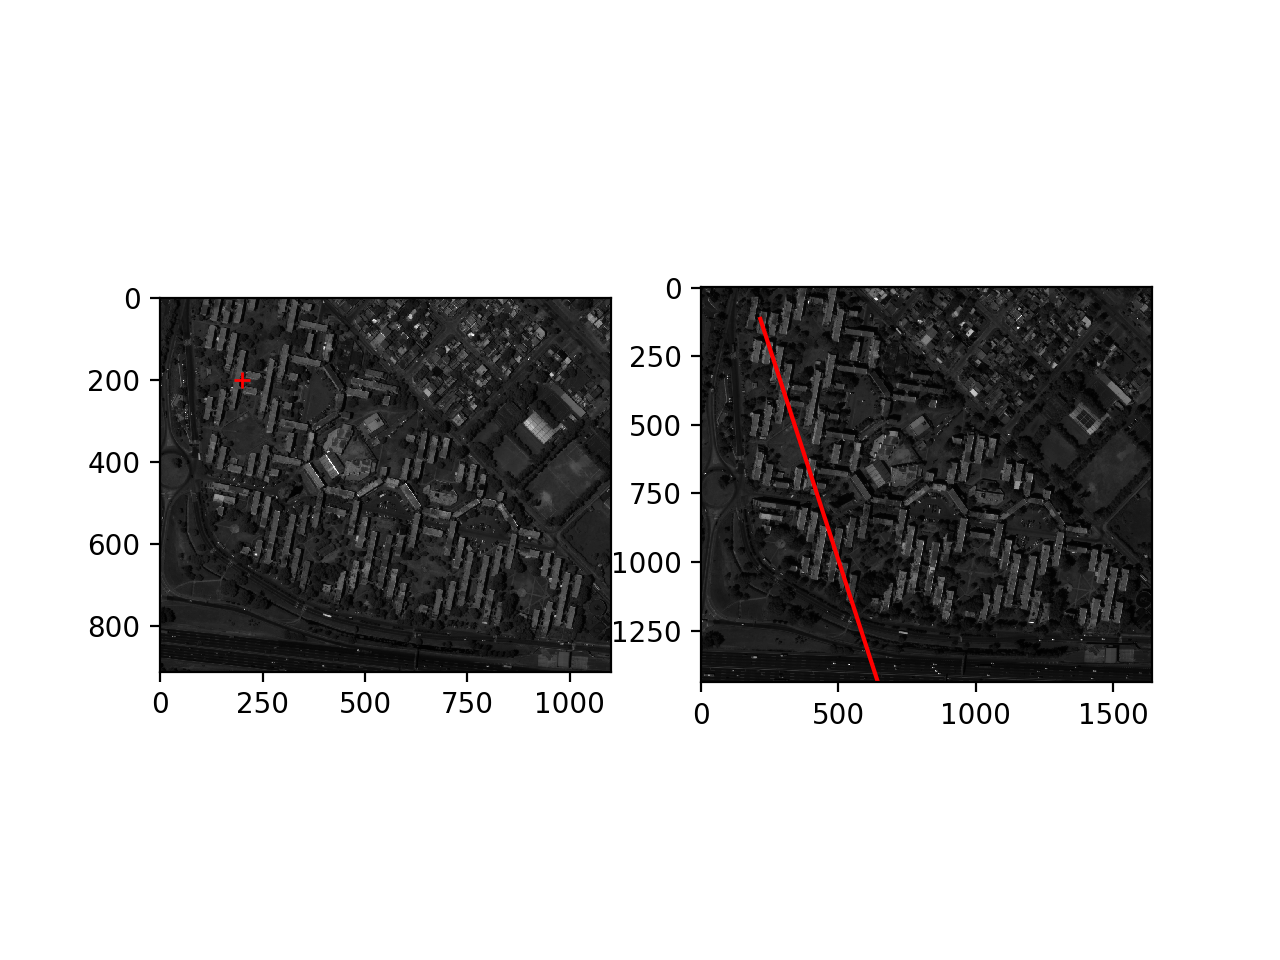

In [42]:
#plt.figure()
f, ax = plt.subplots(1, 2)
ax[0].plot(x0, y0, 'r+')
ax[1].plot(p[:, 0], p[:, 1], 'r-')
ax[0].imshow(im1.squeeze(), cmap='gray')
ax[1].imshow(im2.squeeze(), cmap='gray')

**Exercise 4.** Implement the `rpc_affine_approximation` function. This function computes an affine approximation of the RPC _projection_ function by using a first order Taylor approximation.

Let $P: \mathbb{R}^3\longrightarrow \mathbb{R}^2$ be the _projection_ function. The first order Taylor approximation of $P$ around point $X_0$ is $P(X) = P(X_0) + \nabla P(X_0)(X - X_0)$, which can be rewritten as

$$
P(X) = \nabla P(X_0)X + T
$$

with $\nabla P(X_0)$ the jacobian matrix of size (2, 3) and $T = P(X_0) - \nabla P(X_0) X_0$ a vector of size 2. This can be rewritten as a linear operation by using homogeneous coordinates: with $X = (\lambda, \varphi, h, 1)$ the previous formula becomes $P(X) = AX$, where the (3, 4) matrix $A$ is defined by

$$
A = \begin{pmatrix}
\nabla P(X_0) & T\\
0 & 1
\end{pmatrix}
$$

$A$ is the _affine approximation_ of the RPC _projection_ function $P$ at point $X_0$. The `rpc_affine_approximation` function implemented in this exercise should compute and return $A$.

The gradient $\nabla P(X_0)$ can be computed in at least three different ways:
* formally as $P$ is defined by an explicit formula involving elementary operations only,
* numerically with a finite differences scheme as $P$ is very smooth,
* automatically with [Automatic Differentiation (AD)](http://pythonhosted.org/ad/).

The code below calls your `rpc_affine_approximation` function to compute the affine camera matrix approximating the RPC _projection_ function around the center of the area selected in the map. Then it composes the two affine camera matrices with translations to compensate for the crop offsets.

In [43]:
lat, lon = m.center
h = 0

A = sol.rpc_affine_approximation(rpc1, (lon, lat, h))   # affine projection matrix for first image
print("AX:", np.dot(A, np.array([lon, lat, h, 1])))
print("P(X):", rpc1.projection(lon, lat, h))
B = sol.rpc_affine_approximation(rpc2, (lon, lat, h))   # affine projection matrix for second image
print("BX:", np.dot(B, np.array([lon, lat, h, 1])))
print("P(X):", rpc2.projection(lon, lat, h))

# compensate for the crop offset
A = np.dot(np.linalg.inv(H1), A)
B = np.dot(np.linalg.inv(H2), B)
print(A)

AX: [9.4805833e+03 1.0488536e+04 1.0000000e+00]
P(X): (9480.583300210285, 10488.536006149458)
BX: [1.54774139e+04 1.64389569e+04 1.00000000e+00]
P(X): (15477.413929209968, 16438.956886238564)
[[-1.82225931e+05 -3.73455978e+02  2.10582136e-01 -1.06880524e+07]
 [-4.39523533e+03  2.16156605e+05 -4.23493567e-01  7.19823424e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Exercise 5.** Implement the `affine_fundamental_matrix` function. This function computes the affine fundamental matrix from two affine camera matrices.

In the affine camera model, the epipolar lines are bundles of parallel lines.  These bundles are described by a $3\times 3$ _fundamental matrix_ $F$, such that the epipolar line of a point $\bf x$ in the first image has the equation ${\bf x}^T F{\bf y}=0$ for ${\bf y}$ in the second image.  Since all these lines are parallel, the matrix $F$ has the form $F=\left(\begin{smallmatrix}0 & 0 & a \\ 0 & 0 & b \\ c & d & e \end{smallmatrix}\right)$.  The coefficients of $F$ are found from the two projection matrices $A$ and $B$ by imposing the homogeneous epipolarity constraints $k_1{\bf x}=A{\bf X}$ and $k_2{\bf y}=B{\bf X}$ of a generic point $\bf X$ in space. This is a $6\times 6$ singular system of equations whose solution can be computed explicitly
<!-- (see e.g. Formulas 8.1. and 16.3 from Hartley-Zissserman). -->
(see e.g. formula 17.3 (p.412) from Hartley-Zisserman 2nd, edition).

<!--
The first formula uses the right Moore-Penrose pseudo-inverse $A^+=A^T(AA^T)^{-1}$ that has the property that $AA^+=I$ :


$$
F=[{\bf e}]_\times BA^+
$$
-->

This formula expresses directly each entry of $F$ in terms of determinants computed from the entries of $A$ and $B$ :


$$
F_{ji} = (-1)^{i+j}\mathrm{det}\ \left[ \begin{matrix}\sim {\bf a}^i \\ \sim {\bf b}^j\end{matrix}\right]
$$

where $\sim {\bf a}^i$ denotes the matrix obtained from $A$ by omitting the row ${\bf a}^i$. Thus, for example, the coefficient $F_{11}$ is equal to the determinant of the $4\times 4$ matrix

$$
\left[\begin{matrix}{\bf a}^2\\ {\bf a}^3 \\ {\bf b }^2\\ {\bf b}^3\end{matrix}\right]
$$.

The code below calls your `affine_fundamental_matrix` function to compute the affine fundamental matrix associated to our two images. Check that the 2, 2 top-left block of the matrix is zero.

In [44]:
F = sol.affine_fundamental_matrix(A, B)
F

array([[ 0.00000000e+00, -0.00000000e+00,  7.57075792e+10],
       [-0.00000000e+00,  0.00000000e+00, -2.43850917e+10],
       [-4.95200769e+10,  1.60567654e+10, -1.43521143e+12]])

**Exercise 6.** Implement the `rectifying_similarities_from_affine_fundamental_matrix` function. This function computes two similarities that transform the epipolar lines in a set of matching horizontal lines. The operation of resampling a pair of images such that the epipolar lines become horizontal and aligned is called _stereo rectification_ or _epipolar resampling_.

A similarity is a planar transformation that preserve shapes. It can be made of translations, rotations and scalings.

If the affine fundamental matrix $F$ is given by
$$
F = \begin{pmatrix}
0 & 0 & a\\
0 & 0 & b\\
c & d & e
\end{pmatrix}
$$
then two similarities $S_1$ and $S_2$ that rectify the images are given by

$$
\texttt{S}_1 =
\left(
 \begin{array}{c|c}
  z\texttt{R}_1 &
 \begin{array}{c}
     0\\ t
 \end{array}\\
 \hline
 \begin{array}{cc}
  0 & 0
  \end{array} & 1
\end{array}
\right)
\qquad\qquad
\texttt{S}_2 =
\left(
 \begin{array}{c|c}
  \frac{1}{z}\texttt{R}_2 &
 \begin{array}{c}
     0\\ -t
 \end{array}\\
 \hline
 \begin{array}{cc}
  0 & 0
  \end{array} & 1
\end{array}
\right)
$$

where $z = \sqrt{\frac{r}{s}}$, $t = \frac{e}{2\sqrt{rs}}$ with $r=\sqrt{a^2+b^2}$, $s=\sqrt{c^2+d^2}$ and the two rotations $R_1$ and $R_2$ are given by

$$
 \texttt{R}_1 = \frac{1}{\sqrt{a^2 + b^2}} \begin{bmatrix}b & -a\\ a & b\end{bmatrix}
\qquad\qquad
  \texttt{R}_2 = \frac{1}{\sqrt{c^2 + d^2}} \begin{bmatrix}-d & c\\ -c & -d\end{bmatrix}
$$

The code below calls your `rectifying_similarities_from_affine_fundamental_matrix` function to compute two rectifying similarities for our two images. Then it composes them with a translation to ensures that the whole first crop fits in the rectified image, and finally it produces the resampled rectified images and displays them in a gallery. Flip between the images to see how the buildings move!


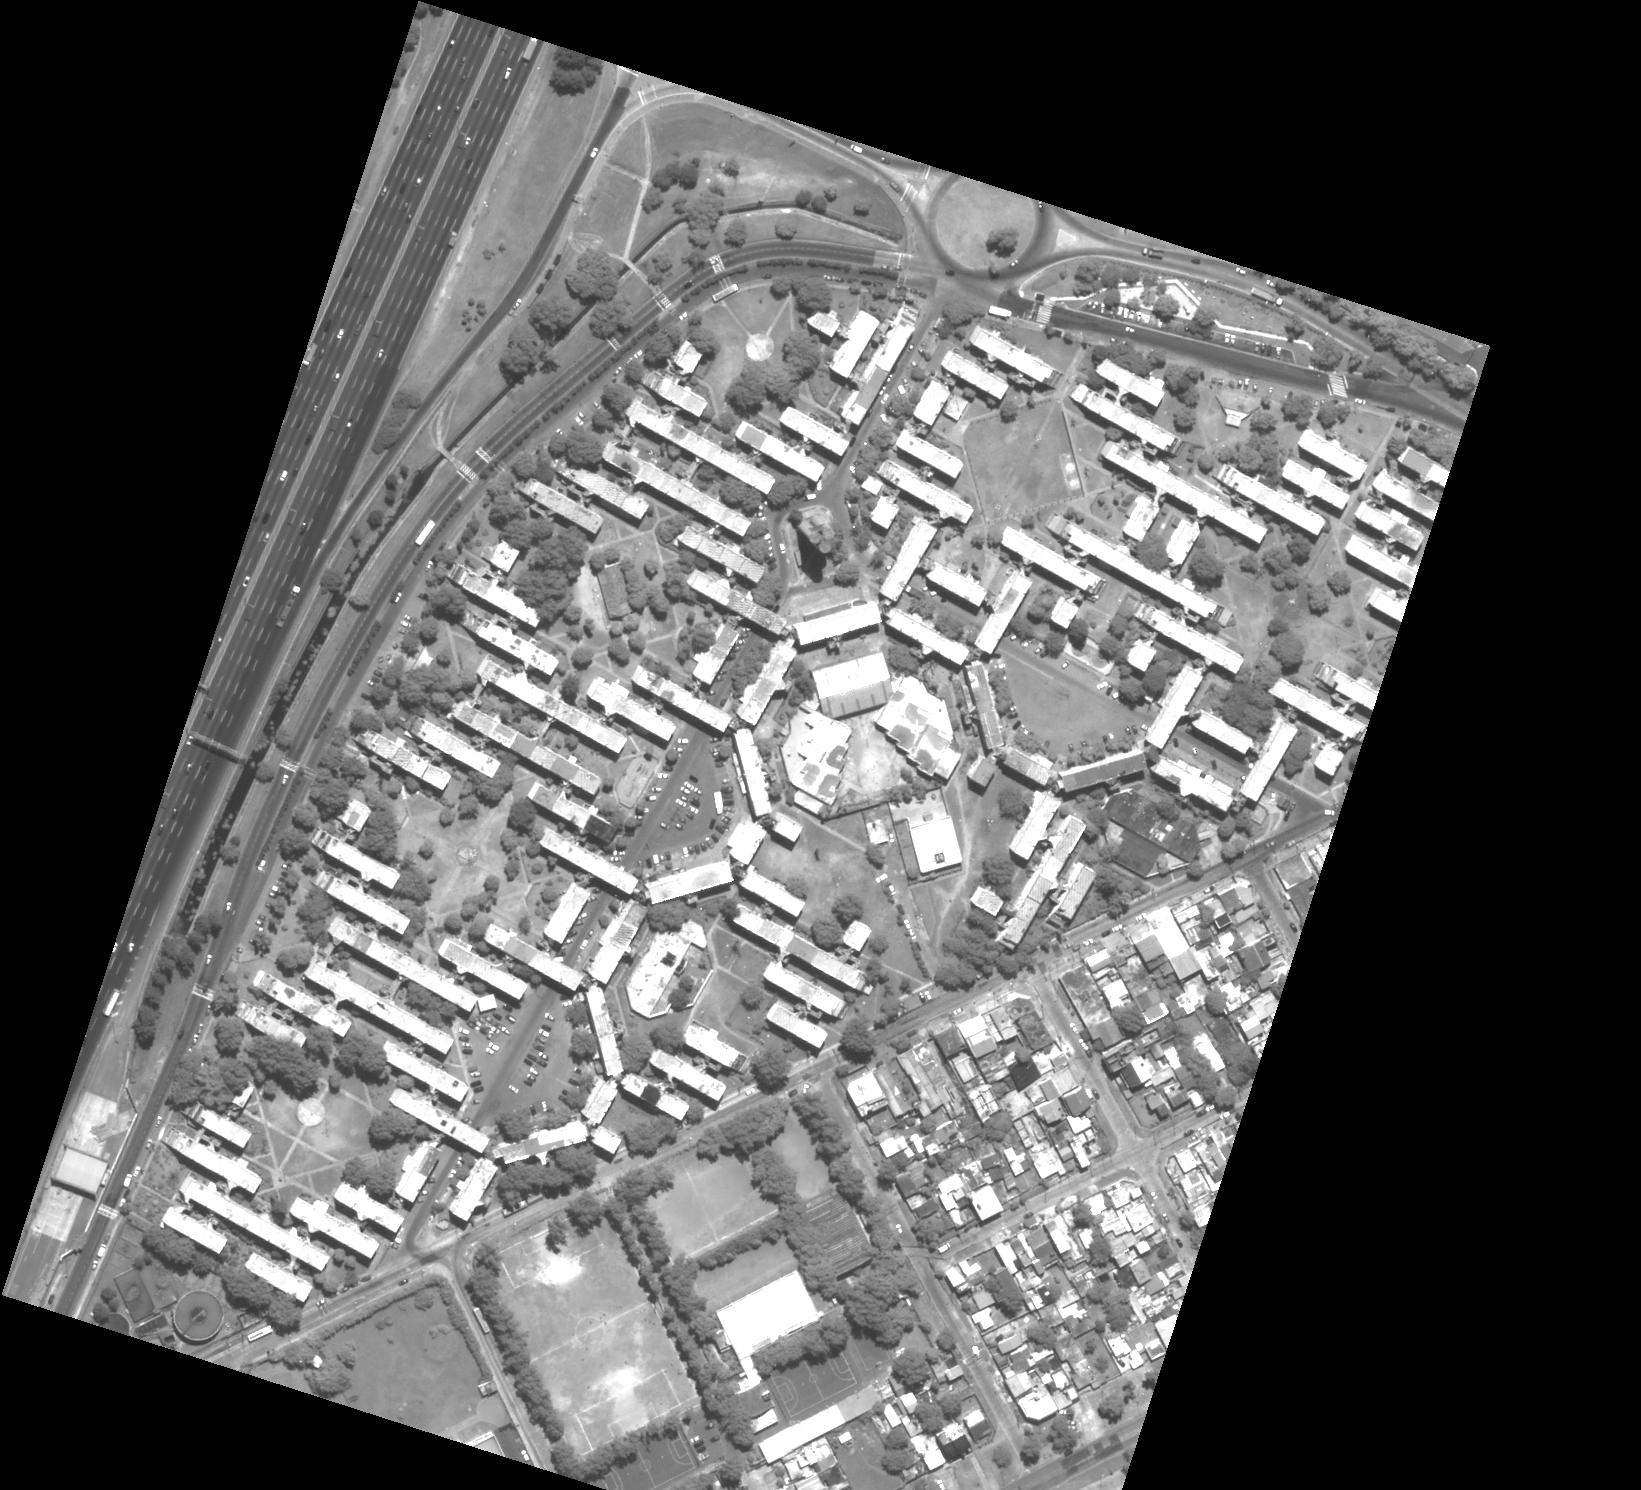
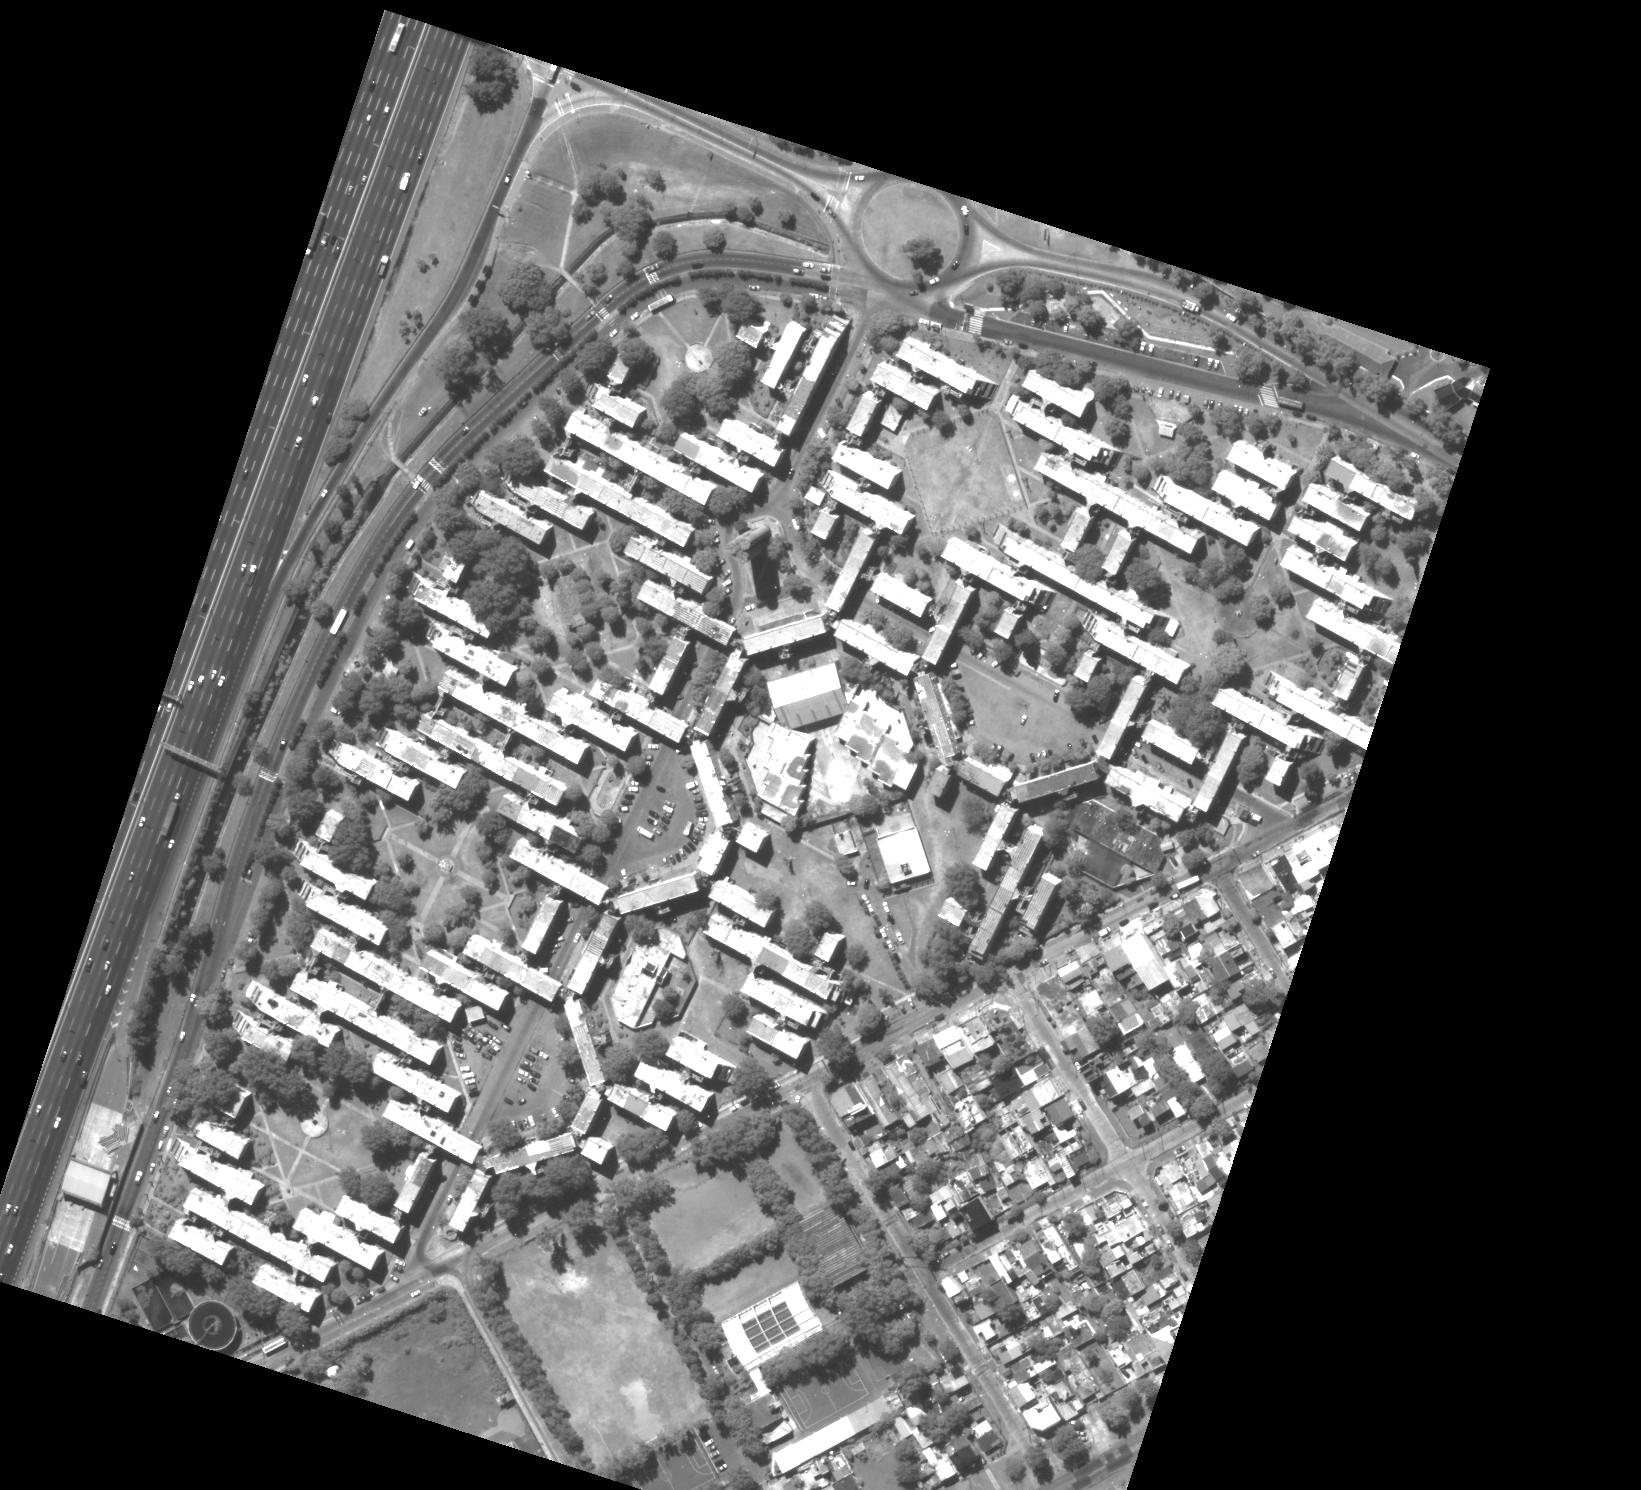

In [45]:
# compute rectifying similarities
S1, S2 = sol.rectifying_similarities_from_affine_fundamental_matrix(F, debug=False)

# read the first crop size
w, h = bbx1[2:]

# pull back top-left corner of the rectified AOI to the origin
pts = ipytools2.points_apply_homography(S1, [[0, 0], [w, 0], [w, h], [0, h]])
x, y, w, h = ipytools2.bounding_box2D(pts)
T = ipytools2.matrix_translation(-x, -y)
S1, S2 = np.dot(T, S1), np.dot(T, S2)
w = int(round(w))
h = int(round(h))

# rectify the crops
crop1 = ipytools.readGTIFF('crop1.tif').squeeze()
crop2 = ipytools.readGTIFF('crop2.tif').squeeze()
rect1 = ndimage.affine_transform(crop1.T, np.linalg.inv(S1), output_shape=(h, w)).T
rect2 = ndimage.affine_transform(crop2.T, np.linalg.inv(S2), output_shape=(h, w)).T

# display the rectifies crops
ipytools.display_gallery([TP1_solutions.simple_equalization_8bit(rect1),
                          TP1_solutions.simple_equalization_8bit(rect2)])
#display_image(TP1_solutions.simple_equalization_8bit(rect1))


**Exercise 7 (Bonus).** Using SIFT keypoint matches, estimate the image shift of the second image that corrects the relative pointing error visible in the previous pair of rectified images.

Implement the function `pointing_error_shift`. This function uses the affine fundamental matrix of a pair of images and a list of keypoint matches to estimate the image translation needed to bring back the keypoints on the epipolar lines of their matches.

The relative pointing error is particularly visible in image pairs (0, 5) and (0, 11). In other image pairs, such as (27, 28), the error is very small and almost invisible.

Corrected stereo-rectified pairs of image crops will be the input for TP4.

The code below shows how to compute a list of matches using the `match_pair` function of the `ipytools2` module. Then it computes the median vertical rectification error.

The next cell calls your `pointing_error_shift` function to estimate the translation needed to correct the second affine camera matrix for the pointing error shift. Then it recomputes the affine fundamental camera matrix and rectifies the images. Now you should see only horizontal displacements!

In [171]:
pts1, pts2 = ipytools2.match_pair('crop1.tif','crop2.tif')

y1 = ipytools2.points_apply_homography(S1, pts1)[:, 1]
y2 = ipytools2.points_apply_homography(S2, pts2)[:, 1]
rectification_error = np.median(y2 - y1)
print(rectification_error)

10.819615074503417


In [169]:
# correct the second affine camera matrix for the pointing error shift
T = sol.pointing_error_shift(F, pts1, pts2)

[[1.       0.       2.206406]
 [0.       1.       0.      ]
 [0.       0.       1.      ]]


In [170]:
B2 = np.dot(T, B)

# recompute the affine fundamental matrix
F2 = sol.affine_fundamental_matrix(A, B2)
S12, S22 = sol.rectifying_similarities_from_affine_fundamental_matrix(F2)
y1 = ipytools2.points_apply_homography(S12, pts1)[:, 1]
y2 = ipytools2.points_apply_homography(S22, pts2)[:, 1]
rectification_error = np.median(y2 - y1)
print(rectification_error)

9.121624915942192



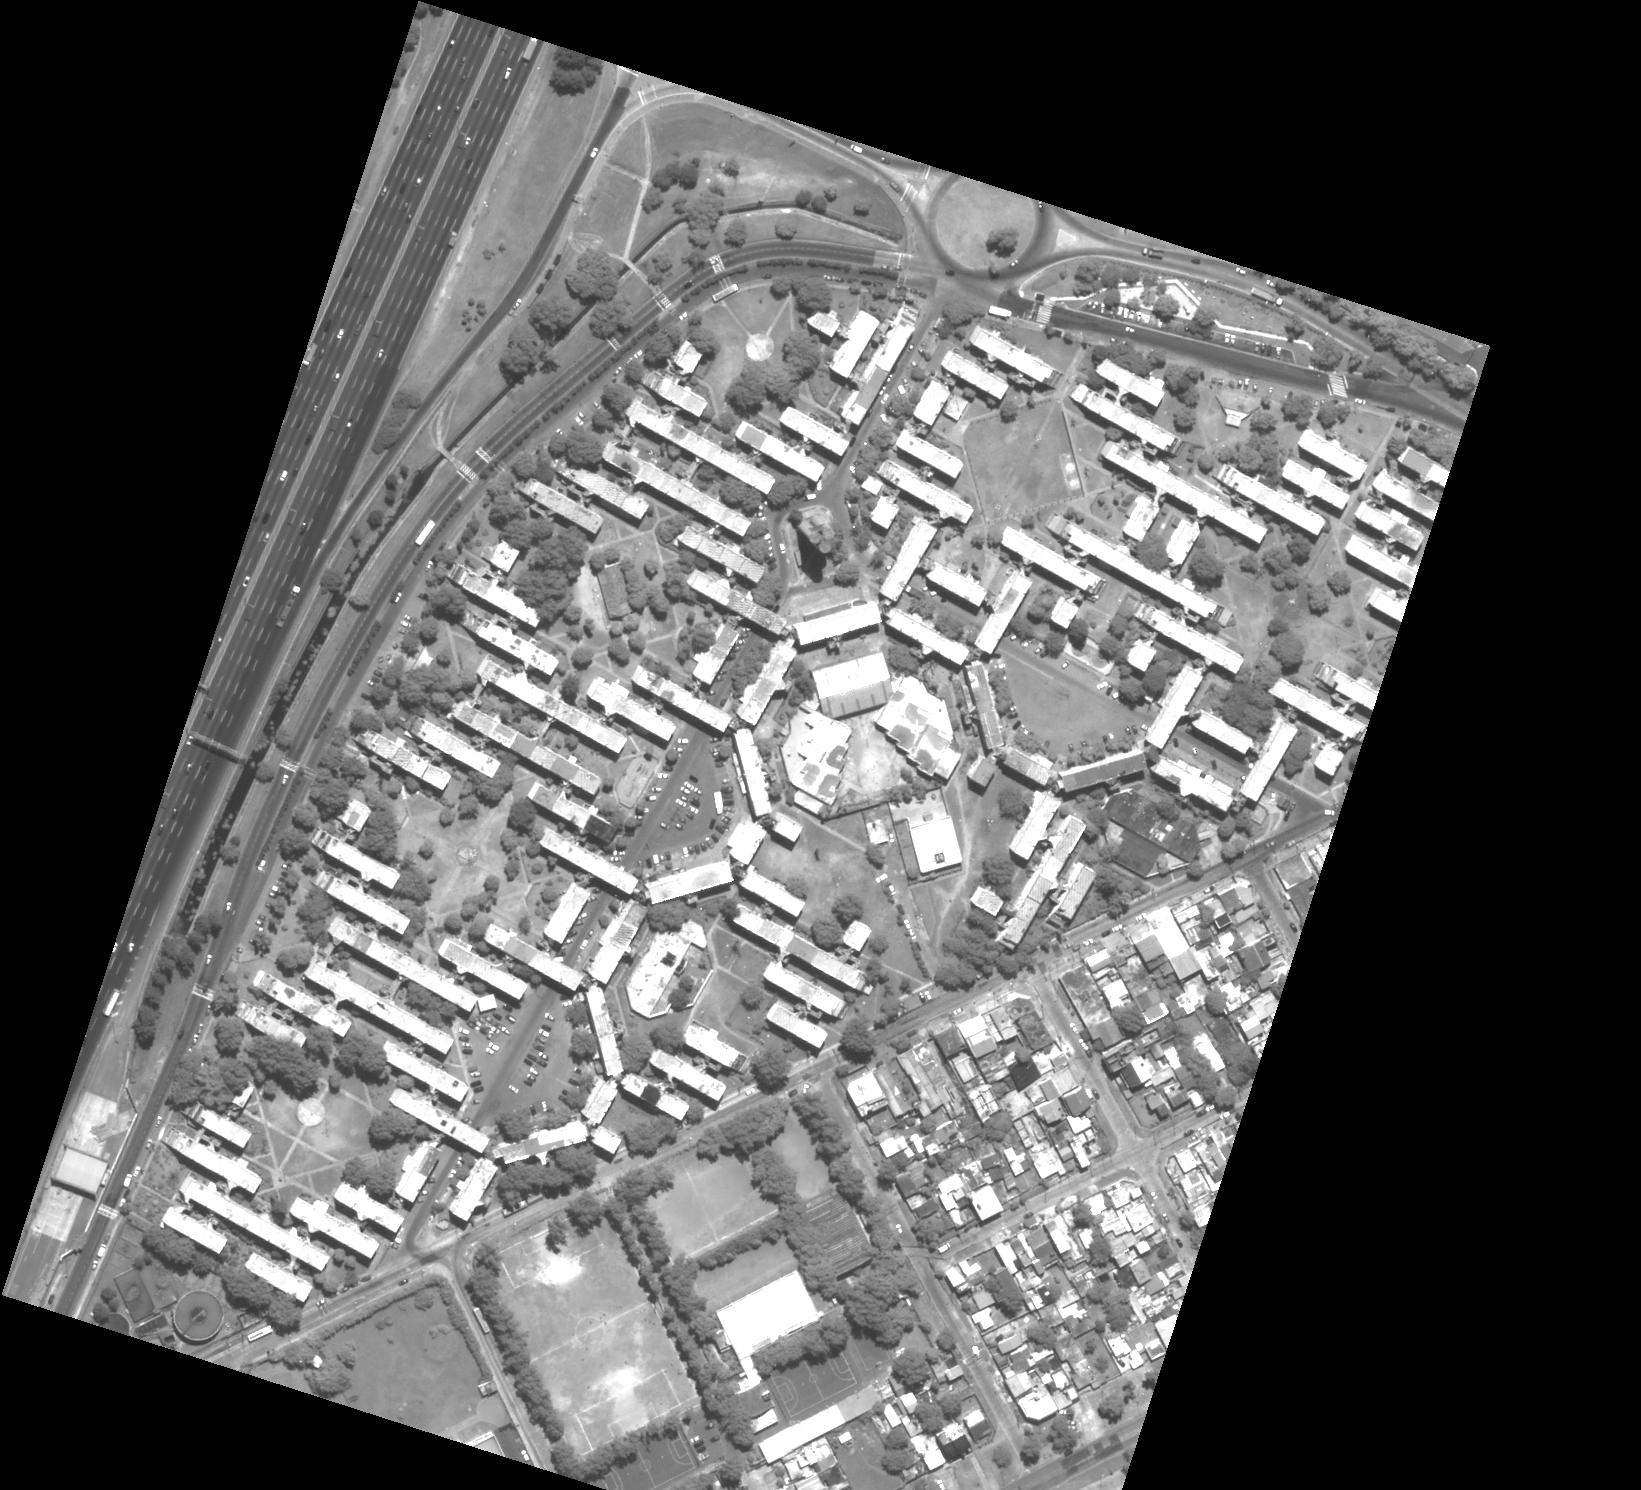
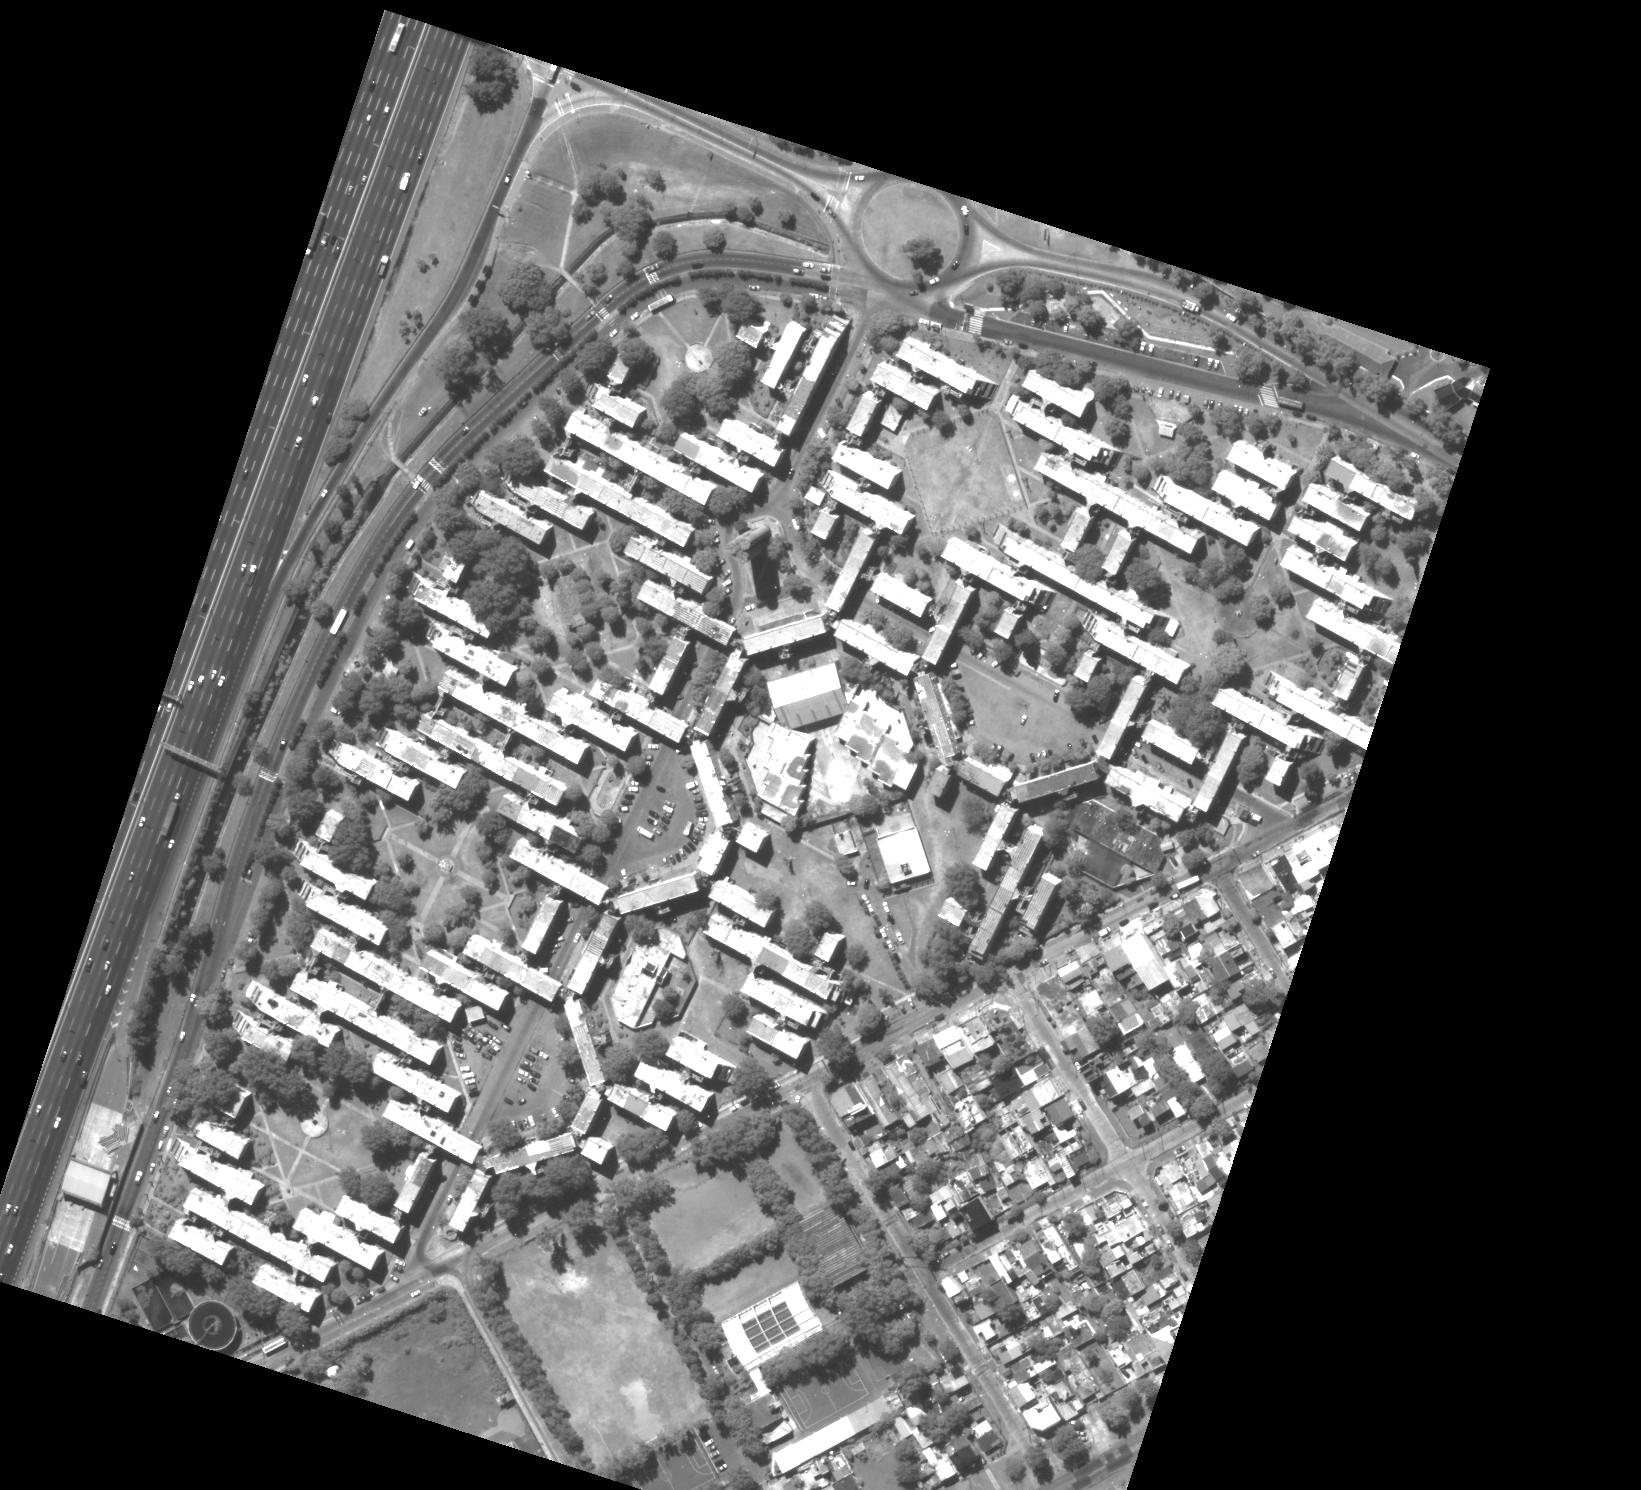

In [168]:
# compute rectifying similarities
S1, S2 = sol.rectifying_similarities_from_affine_fundamental_matrix(F)

# read the first crop size
w, h = bbx1[2:]

# pull back top-left corner of the rectified AOI to the origin
pts = ipytools2.points_apply_homography(S1, [[0, 0], [w, 0], [w, h], [0, h]])
x, y, w, h = ipytools2.bounding_box2D(pts)
T = ipytools2.matrix_translation(-x, -y)
S1, S2 = np.dot(T, S1), np.dot(T, S2)
w = int(round(w))
h = int(round(h))

# rectify the crops
crop1 = ipytools.readGTIFF('crop1.tif').squeeze()
crop2 = ipytools.readGTIFF('crop2.tif').squeeze()
rect1 = ndimage.affine_transform(crop1.T, np.linalg.inv(S1), output_shape=(h, w)).T
rect2 = ndimage.affine_transform(crop2.T, np.linalg.inv(S2), output_shape=(h, w)).T

# display the rectifies crops
ipytools.display_gallery([TP1_solutions.simple_equalization_8bit(rect1),
                          TP1_solutions.simple_equalization_8bit(rect2)])